In [4]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



In [5]:
def compare_clahe(img_path):
    # Load the input image
    img = cv2.imread(img_path)

    # Convert to LAB color space
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split LAB channels
    l_channel, a_channel, b_channel = cv2.split(img_lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_channel_clahe = clahe.apply(l_channel)

    # Merge LAB channels back together
    img_lab_clahe = cv2.merge((l_channel_clahe, a_channel, b_channel))

    # Convert back to RGB color space
    img_clahe = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2BGR)

    # Display the results side by side
    # img_concatenated = np.concatenate((img, img_clahe), axis=1)
    # cv2.imshow("Original Image vs. CLAHE Image", img_concatenated)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    return img, img_clahe

In [59]:

def get_optimal_gamma(img):
    # Load the input image
    mean_intensity = np.mean(img)

    # Calculate the optimal gamma value based on the mean intensity
    if mean_intensity < 50:
        gamma = 1.5
    elif mean_intensity < 100:
        gamma = 1.75
    elif mean_intensity < 150:
        gamma = 2.0
    elif mean_intensity < 200:
        gamma = 2.25
    else:
        gamma = 2.5

    return gamma

In [36]:
def gamma_correction(img, gamma):
    img_gamma = np.power(img / float(np.max(img)), gamma)
    img_gamma = np.uint8(img_gamma * 255)
    return img_gamma

In [23]:
# apply CLAHE to the V channel of HSV
def apply_clahe_hsv(img):
    # Convert to HSV color space
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Split HSV channels
    h_channel, s_channel, v_channel = cv2.split(img_hsv)

    # Apply CLAHE to V channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    v_channel_clahe = clahe.apply(v_channel)

    # Merge HSV channels back together
    img_hsv_clahe = cv2.merge((h_channel, s_channel, v_channel_clahe))


    return img_hsv_clahe
   

In [25]:
def apply_clahe_lab(img):
    # Convert to LAB color space
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split LAB channels
    l_channel, a_channel, b_channel = cv2.split(img_lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_channel_clahe = clahe.apply(l_channel)

    # Merge LAB channels back together
    img_lab_clahe = cv2.merge((l_channel_clahe, a_channel, b_channel))

    return img_lab_clahe

In [67]:
def preprocess_image(image):
    # hsv = apply_clahe_hsv(image)
    gamma = get_optimal_gamma(image)
    # image = gamma_correction(image, gamma)
    gamma_corrected = np.copy(image)
    hsv = apply_clahe_hsv(image)
    # hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # # Define the range of skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # define the range of skin color in LAB
    # lower_skin = np.array([0, 20, 135], dtype=np.uint8)
    # upper_skin = np.array([255, 170, 255], dtype=np.uint8)

    # Create a mask to segment the skin color
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Apply a series of erosions and dilations to remove noise and small objects
    kernel = np.ones((5, 5), np.uint8)
    skin_mask = cv2.erode(skin_mask, kernel, iterations=2)
    skin_mask = cv2.dilate(skin_mask, kernel, iterations=2)

    # Blur the mask to help remove shadows
    skin_mask = cv2.GaussianBlur(skin_mask, (5, 5), 0)

    # Find the largest contour (assumed to be the hand) and draw it on a blank mask
    contours, _ = cv2.findContours(
        skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    hand_mask = np.zeros_like(skin_mask)
    cv2.drawContours(hand_mask, [max_contour], -1, 255, thickness=cv2.FILLED)

    # Apply a closing morphological operation to reduce noise around the hand's edges
    kernel = np.ones((7, 7), np.uint8)
    hand_mask = cv2.morphologyEx(hand_mask, cv2.MORPH_CLOSE, kernel)

    return hand_mask


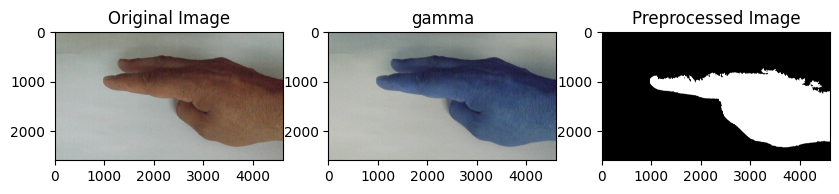

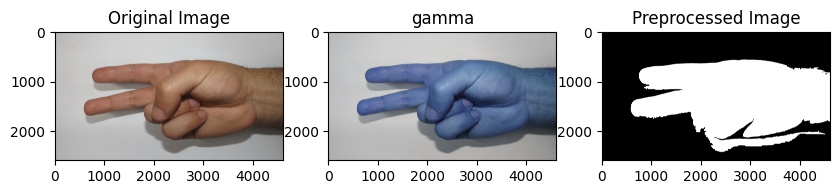

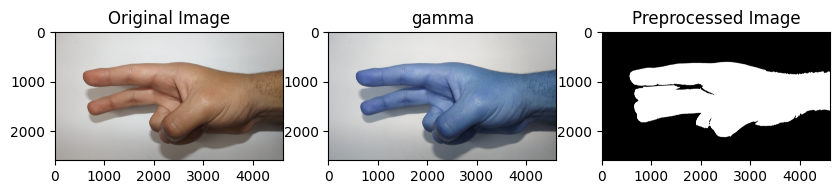

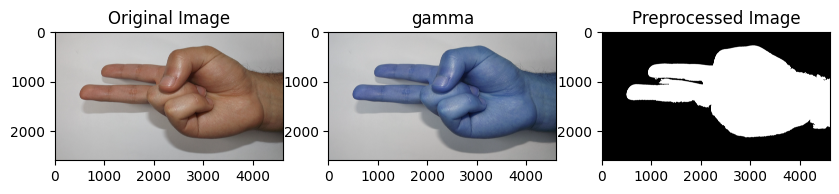

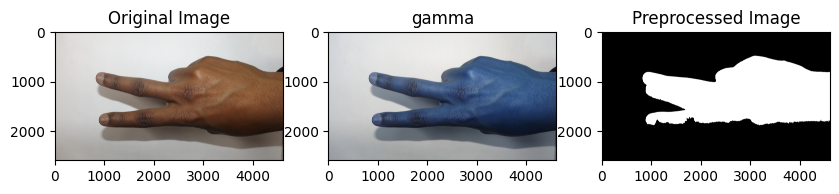

In [68]:
def test_stages(channel, index):
    # Load a sample images from the dataset

    sample_image_path = 'dataset/men/' + channel + '/' + channel + '_men (' + str(index) + ').JPG'
    
    ## compare the original image with the CLAHE image
    # img = cv2.imread(sample_image_path)
    img, calahe = compare_clahe(sample_image_path)


    # Preprocess the image
    preprocessed_image, gamma_corrected = preprocess_image(img)
    # preprocessed_image_calahe = preprocess_image_calahe(img)



    # Display the original, preprocessed images and features
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[1].imshow(gamma_corrected, cmap='gray')
    axes[1].set_title("gamma")
    axes[2].imshow(preprocessed_image, cmap='gray')
    axes[2].set_title("Preprocessed Image")
    
    plt.show()

# Test the stages of the preprocessing pipeline by atterating over the channel with 5 indexes
for index in range(1, 6):
    test_stages(str(2), str(index))